## About
This program estimates the optimal stock portfolio allocations using Monte Carlo simulations and Modern Portfolio Theory introduced by Markowitz.

## Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

## Set the current portfolio

In [2]:
tickers = ['GOOG', 'AMZN', 'TSLA', 'DIS', 'BABA', 'BTC-USD']
value = [200, 100, 300, 100, 250, 50]
print('Total portfolio value is $' + str(sum(value)))

Total portfolio value is $1000


## Download the historical data

#### Set start date and end date

In [3]:
start_date = datetime.now() - relativedelta(months=12)
start_date = start_date.strftime('%Y-%m-%d')
end_date = str(datetime.now().strftime('%Y-%m-%d'))

#### Fetch data from Yahoo Finance


In [4]:
df = yf.download(tickers, start=start_date, end=end_date)['Close']
df.dropna(inplace=True)

[*********************100%***********************]  6 of 6 completed


#### Plot the source data

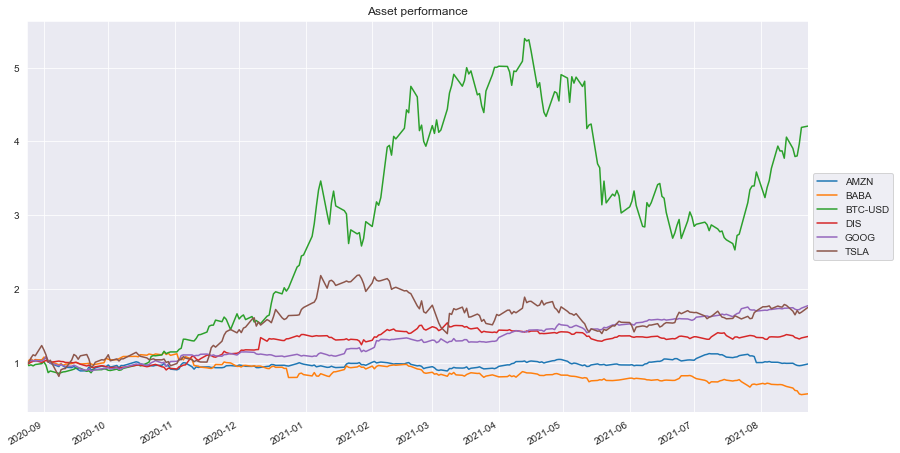

In [5]:
ax = (df/df.iloc[0]).plot(figsize=(14,8),title='Asset performance')
ax.set_xlim(start_date, end_date)
ax.set(xlabel='')
ax.autoscale(tight=True, axis='x')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

#### Obtain risk free return using US treasury yield 10 years data

In [6]:
rf_return = yf.download('^tnx', start_date, end_date)['Close']
rf_return.dropna(axis=0, inplace=True)
# convert to decimal
rf_return = rf_return[-1]/100

[*********************100%***********************]  1 of 1 completed


#### Set risk free premium and number of trading days in a year

In [7]:
rf_premium = 0.05
trading_days = 250

## Current portfolio

#### Calculate portfolio expected return, volatility and Sharpe ratio

In [8]:
log_return = np.log(df/df.shift(1))
weight = [x/sum(value) for x in value]
pf_return = np.sum(log_return.mean()*weight) * trading_days
pf_volatility = np.sqrt(np.dot(weight, np.dot(log_return.cov() * trading_days, weight)))
pf_sharpe = (pf_return - rf_return)/pf_volatility

#### Plot the current portfolio

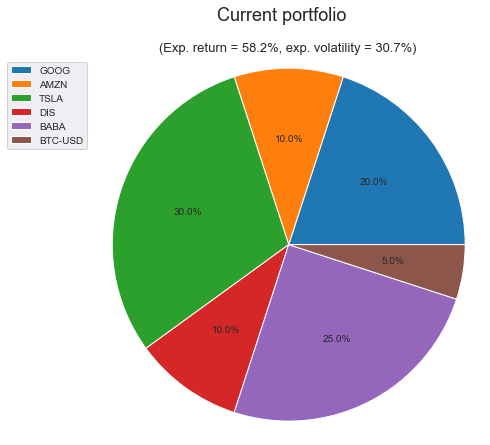

In [9]:
curr_vol = 100*pf_volatility
curr_return = 100*pf_return
weight = [x*100 for x in value]
plt.pie(weight, autopct='%1.1f%%')
plt.suptitle('Current portfolio',fontsize=18)
plt.title(f'(Exp. return = {round(curr_return, 1)}%, \
exp. volatility = {round(curr_vol, 1)}%)',fontsize=13)
plt.axis('equal')
plt.legend(labels=tickers, bbox_to_anchor=(0,1))
fig = plt.gcf()
fig.set_size_inches(7,7)

In [10]:
# for plotting the efficient frontier
curr_vol /= 100
curr_return /= 100

## Perform Monte Carlo simulations to find the efficient frontier

In [11]:
num_assets = len(tickers)
pf_return = []
pf_volatility = []
pf_sharpe = []
weight_coeff = [[] for i in range(1, num_assets+1)]
num_iter = 10000

# calculate portfolio return, volatility, and Sharpe ratio of each configuration
for x in range(num_iter):
    weight = np.random.random(num_assets)
    weight /= np.sum(weight)
    pf_return.append(np.sum(log_return.mean()*weight) * trading_days)
    pf_volatility.append(np.sqrt(np.dot(weight.T, np.dot(log_return.cov() * trading_days, weight))))
    pf_sharpe.append((pf_return[-1] - rf_return)/pf_volatility[-1] )
    # store the weight coefficients
    for i in range(num_assets):
        weight_coeff[i].append(weight[i])

In [12]:
# convert to numpy arrays
pf_return = np.array(pf_return)
pf_volatility = np.array(pf_volatility)
weight_coeff = np.array(weight_coeff)
pf_sharpe = np.array(pf_sharpe)

In [13]:
# store in a data frame
pf = pd.DataFrame({'Volatility': pf_volatility, 'Return' :pf_return, 'Sharpe' :pf_sharpe})
for i in range(num_assets):
    pf[tickers[i]] = weight_coeff[i]

## Efficient frontier with minimum volatility

#### Obtain the allocation for efficient frontier with minimum volatility

In [14]:
err = 1e-6
min_vol = pf['Volatility'].min()
min_vol_pf = pf[(pf['Volatility'] < min_vol + err) & (pf['Volatility'] > min_vol - err)].iloc[0]
print('A portfolio that gives the minimum volatility')
print('Allocation in USD:')
min_vol_pf.iloc[3:].apply(lambda x: x*sum(value))

A portfolio that gives the minimum volatility
Allocation in USD:


GOOG       240.926155
AMZN       195.033828
TSLA        18.119281
DIS        342.651360
BABA       201.271190
BTC-USD      1.998186
Name: 9042, dtype: float64

#### Plot the portfolio

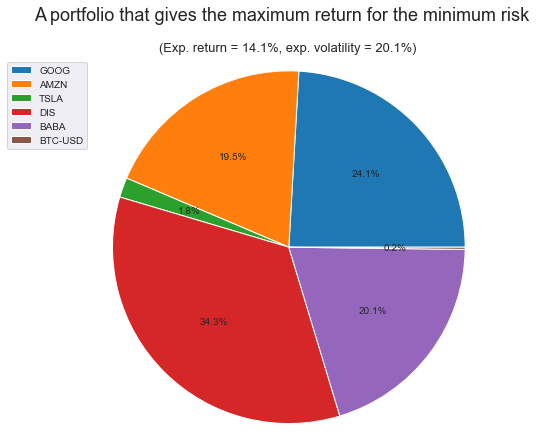

In [15]:
vol = 100*min_vol_pf['Volatility']
returns = 100*min_vol_pf['Return']
weight = 100*min_vol_pf.drop(min_vol_pf.index[[0,1,2]])
plt.pie(weight, autopct='%1.1f%%')
plt.suptitle('A portfolio that gives the maximum return for the minimum risk',fontsize=18)
plt.title(f'(Exp. return = {round(returns, 1)}%, \
exp. volatility = {round(vol, 1)}%)',fontsize=13)
plt.axis('equal')
plt.legend(labels=tickers, bbox_to_anchor=(0,1))
fig = plt.gcf()
fig.set_size_inches(7,7)

## Efficient frontier with maximum Sharpe ratio

#### Obtain the allocation for efficient frontier with maximum Sharpe ratio (market portfolio)

In [16]:
max_sharpe = pf['Sharpe'].max()
market_pf = pf[(pf['Sharpe'] < max_sharpe + err) & (pf['Sharpe'] > max_sharpe - err)].iloc[0]
print('A portfolio that gives the max. Sharpe ratio')
print('Allocation in USD:')
market_pf.iloc[3:].apply(lambda x: x*sum(value))

A portfolio that gives the max. Sharpe ratio
Allocation in USD:


GOOG        69.052937
AMZN         3.920925
TSLA       216.809003
DIS        155.690302
BABA       497.289244
BTC-USD     57.237588
Name: 3253, dtype: float64

#### Plot the portfolio

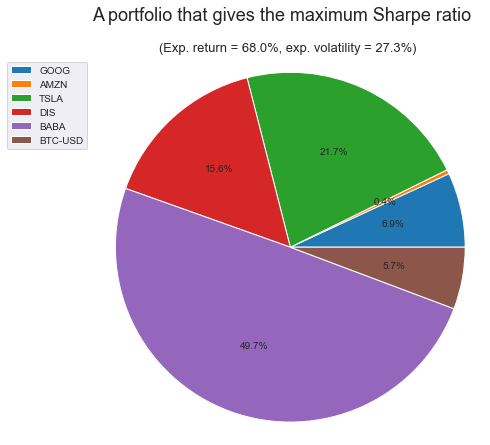

In [17]:
vol = 100*market_pf['Volatility']
returns = 100*market_pf['Return']
weight = 100*market_pf.drop(market_pf.index[[0,1,2]])
plt.pie(weight, autopct='%1.1f%%')
plt.suptitle('A portfolio that gives the maximum Sharpe ratio',fontsize=18)
plt.title(f'(Exp. return = {round(returns, 1)}%, \
exp. volatility = {round(vol, 1)}%)',fontsize=13)
plt.axis('equal')
plt.legend(labels=tickers, bbox_to_anchor=(0,1))
fig = plt.gcf()
fig.set_size_inches(7,7)

#### Plot the efficient frontier

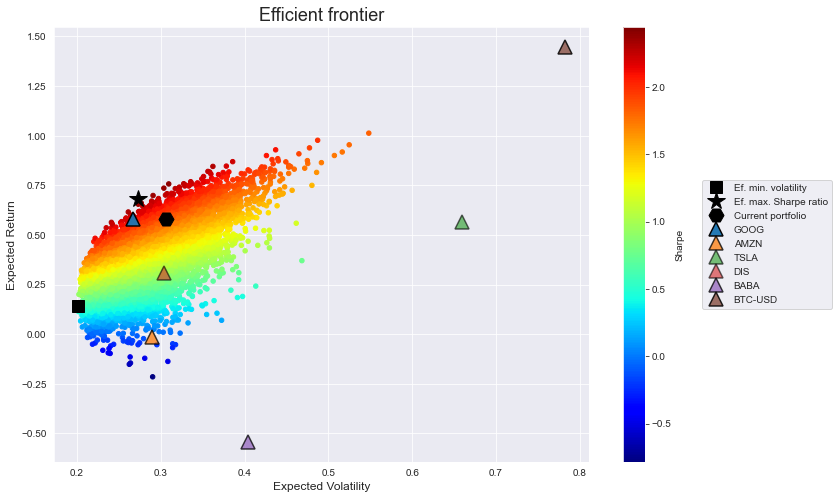

In [18]:
pf.plot(x='Volatility', y='Return', kind='scatter', c='Sharpe', cmap='jet', 
        figsize=(12, 8), sharex=False);
plt.plot(min_vol_pf['Volatility'], min_vol_pf['Return'], color='black', marker='s',  
         markersize=12, linestyle="None", label='Ef. min. volatility')
plt.plot(market_pf['Volatility'], market_pf['Return'], color='black', marker='*',  
         markersize=18, linestyle="None", label='Ef. max. Sharpe ratio')
plt.plot(curr_vol, curr_return, color='black', marker='H',  
         markersize=15, linestyle="None", label='Current portfolio')
for t in tickers:
    rgb = np.random.rand(3,)
    plt.plot(log_return[t].std()*trading_days ** 0.5, log_return[t].mean()*trading_days,
             alpha=np.random.uniform(low=0.25, high=1), marker='^',  markersize=14,
             linestyle="None", label=t, markeredgewidth=1.5, markeredgecolor='black')
plt.title('Efficient frontier', fontsize=18)
plt.xlabel('Expected Volatility', fontsize=12)
plt.ylabel('Expected Return', fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5));